In [11]:
#Traitement de texte
import pandas as pd
df = pd.read_csv('DONNES/train_cap2018.csv')
df.head()


,fulltext,sentences,words,letters.all,syllables,punct,avg.sentc.length,avg.word.length,avg.syll.word,sntc.per.word,...,Maas lgV0,MATTR,MSTTR,MTLD,Root TTR,Summer,TTR.1,Uber index,Yule's K,level1
0,\r\r\n The Eiffel Tower The Eiffel Tower ...,16,233,1116,363,32,14.562500,4.789700,1.557940,0.068670,...,4.96,0.72,0.70,70.74,8.98,0.88,0.59,24.30,146.62,C2
1,\r\r\n The Court Green burglar arrested A...,7,180,866,268,18,25.714286,4.811111,1.488889,0.038889,...,5.07,0.74,0.76,107.12,8.57,0.89,0.64,26.14,141.98,C2
2,\r\r\n Thank you for giving us the opport...,10,180,861,269,20,18.000000,4.783333,1.494444,0.055556,...,5.99,0.77,0.78,161.93,9.62,0.92,0.72,35.15,62.96,C2
3,\r\r\n The international AI conference ca...,10,180,872,281,20,18.000000,4.844444,1.561111,0.055556,...,5.49,0.77,0.81,141.10,9.09,0.90,0.68,30.11,70.99,C2
4,\r\r\n I believe that the creative writin...,11,187,849,283,29,17.000000,4.540107,1.513369,0.058824,...,4.61,0.68,0.64,70.69,7.97,0.87,0.58,22.02,124.11,C2


In [17]:
from io import StringIO

col = ['fulltext', 'level1']
df = df[col]
df = df[pd.notnull(df['fulltext'])]

df.columns = ['fulltext', 'level1']
df['category_id'] = df['level1'].factorize()[0]
category_id_df = df[['level1', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'level1']].values)

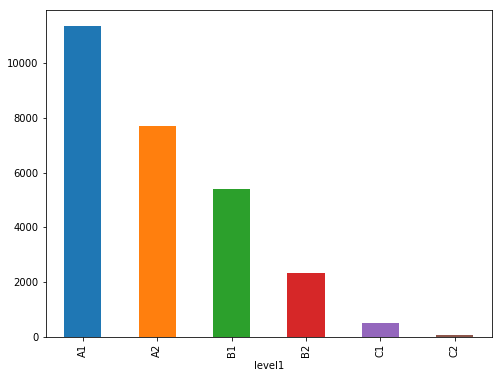

In [18]:
#On a beaucoup plus de niveau A1 que de niveau C2, 
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('level1').level1.count().plot.bar(ylim=0)
plt.show()

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

#calcule un vecteur tf-idf pour chaque texte en anglais
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.fulltext).toarray()
labels = df.category_id
features.shape

#Soit pour les 27310 récits en anglais ils sont representés par 28555 caractéristiques

(27310, 28555)

In [40]:
#ATTENTION TEMPS D'EXECUTION TRES LONG
#On cherche ici une correlation entre les termes et le niveau d'anglais

from sklearn.feature_selection import chi2
import numpy as np


N = 2
for level1, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(level1))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'A1':
  . Most correlated unigrams:
. live
. busy
  . Most correlated bigrams:
. busy good
. good evening
# 'A2':
  . Most correlated unigrams:
. feed
. dog
  . Most correlated bigrams:
. talk phone
. feed dog
# 'B1':
  . Most correlated unigrams:
. bowling
. bottles
  . Most correlated bigrams:
. shots turn
. plastic bottles
# 'B2':
  . Most correlated unigrams:
. discrimination
. apply
  . Most correlated bigrams:
. absolutely amazing
. amazing job
# 'C1':
  . Most correlated unigrams:
. vote
. council
  . Most correlated bigrams:
. green business
. student council
# 'C2':
  . Most correlated unigrams:
. pettigrew
. robot
  . Most correlated bigrams:
. french revolution
. emotional intelligence


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['fulltext'], df['level1'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [22]:
#Testons quelques predictions :

print(clf.predict(count_vect.transform(["The Court Green burglar arrested A 23 years old man was arrested at 6am in connection with the series of burglaries in and around Court Green that had been taking place over the past 15 months. The suspect's name has not been released yet. The police had made every effort to catch the burglar, such as increasing the police patrols in the area, setting up undercover surveillance, having a publicity campaign published in this local paper, and promising a $300 reward for information. John White, police lieutenant, confirmed that people felt concerned by these efforts and were willing to help the police. Thanks to a local resident who saw somebody acting suspiciously in the neighbourhood, the police patrolling nearby managed to give chase to the suspect and eventually cornered him in Hamilton Road at 6am. The man is currently being held in custody for police questioning and is bound to be charged for the crimes by the end of tomorrow. James Denver, a Court Green inhabitant, reported he felt greatly relieved to know that the burglar had been arrested. "])))

['A2']


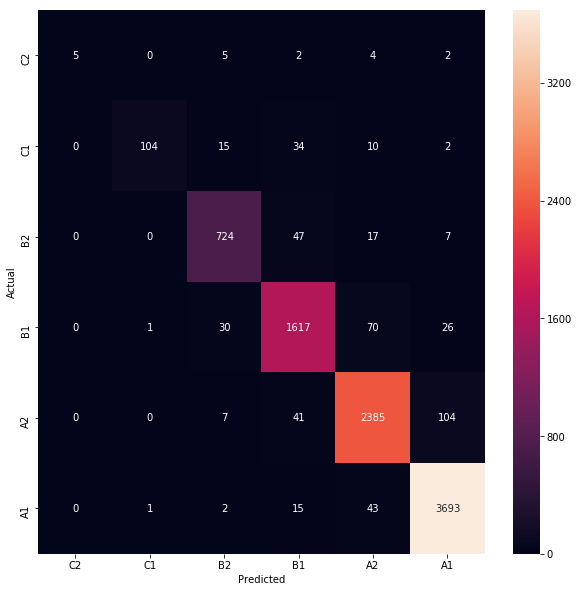

In [28]:
#ATTENTION LONG A EXECUTER
#Utilisation de LinearSVC pour 

from sklearn.svm import LinearSVC
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.level1.values, yticklabels=category_id_df.level1.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [31]:
#Entre les résultats attendu et les résultats obtenus on observe des différences
#Etudions donc d'où viennet ces incohérences 
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['level1', 'fulltext']])
      print('')

'C1' predicted as 'B2' : 15 examples.


,level1,fulltext
151,C1,"\r\r\n Good day, I'd really want to thank..."
438,C1,\r\r\n I would like to speak about the tw...
506,C1,\r\r\n One of the most important trait of...
219,C1,"\r\r\n Hi Everybody, First of all, I woul..."
252,C1,"\r\r\n Dear Bob, I know that you live a v..."
452,C1,\r\r\n My son was at a national universi...
181,C1,"\r\r\n Dear Mr Robinson, I'm really glad ..."
414,C1,\r\r\n I believe that a good education is...
242,C1,\r\r\n The French Budget Minister guilty ...
221,C1,"\r\r\n In France, communication are a lit..."



'B1' predicted as 'B2' : 30 examples.


,level1,fulltext
4782,B1,"\r\r\n Dear Daddy, I know you are hoping ..."
5679,B1,"\r\r\n Today, there are more and more hea..."
5225,B1,\r\r\n My work consists in moving at the ...
3745,B1,\r\r\n For christmas I had a tablet. I am...
6484,B1,\r\r\n Let me talk about french health an...
4092,B1,\r\r\n I'm going to apply for a job which...
6662,B1,"\r\r\n John, we had a critical meeting on..."
5297,B1,"\r\r\n In France, there are things and be..."
4792,B1,"\r\r\n Tim, Few years ago, I had to go to..."
8253,B1,"\r\r\n Before I retired,15 years ago, I w..."



'C1' predicted as 'B1' : 34 examples.


,level1,fulltext
350,C1,\r\r\n Good evening and welcome everyone....
278,C1,"\r\r\n Dear John, I am very glad that you..."
154,C1,"\r\r\n Dear Mr. Smith, I wanted to inform..."
379,C1,"\r\r\n Dear Nicholas, I heard last week T..."
408,C1,\r\r\n I have studied during one year in ...
276,C1,"\r\r\n Okay, I will tell you a story of a..."
316,C1,\r\r\n Hello. It's a real pleasure to wel...
275,C1,"\r\r\n Dear Henry, I know that it cannot ..."
335,C1,\r\r\n Have you ever seen &quot;Big Fish&...
325,C1,\r\r\n Having graduated from a university...



'B2' predicted as 'B1' : 47 examples.


,level1,fulltext
875,B2,\r\r\n I work as a teacher at a French Hi...
2272,B2,\r\r\n Sara is a brilliant manager. When ...
1687,B2,\r\r\n I'm familiar with a number of tech...
1324,B2,\r\r\n About your private and professionn...
2436,B2,\r\r\n It happened the last january in a ...
1579,B2,"\r\r\n The night was dark and cold, it wa..."
858,B2,\r\r\n Watch One Day an adaptation of Dav...
2465,B2,"\r\r\n Hello Ian, I have received your le..."
2103,B2,\r\r\n In my country we have a lot of law...
2764,B2,\r\r\n The meeting today was about the de...



'A2' predicted as 'B1' : 41 examples.


,level1,fulltext
14124,A2,"\r\r\n I met my friend, Aurelija, when I ..."
13792,A2,\r\r\n I like traveling. I have visited s...
13564,A2,\r\r\n My job deals whith art and I work ...
10259,A2,\r\r\n Hello my friend !I 'm proposing th...
8312,A2,\r\r\n I'm studying economics and managem...
13125,A2,\r\r\n I haven't never travelling. My fir...
8522,A2,"\r\r\n Hi, i'am a student, in civil engin..."
14298,A2,"\r\r\n Hello Mike, I write to you to tell..."
15501,A2,\r\r\n I recently went to the restaurant ...
8277,A2,\r\r\n I work in local administration. I ...



'A1' predicted as 'B1' : 15 examples.


,level1,fulltext
23996,A1,\r\r\n Tomorrow : participation in an exe...
21331,A1,"\r\r\n Well, I know a very good Chinese r..."
24587,A1,"\r\r\n Dear sir, I've received your messa..."
19323,A1,\r\r\n I like celebrate the new year beca...
20309,A1,"\r\r\n Hello everybody,As you don't know ..."
16600,A1,"\r\r\n Dear team, I have received your p..."
16796,A1,"\r\r\n Dear client, Thank you for the inf..."
22851,A1,"\r\r\n Today, I am eating in Indian Resta..."
18585,A1,"\r\r\n Dear Bill,We run in a way to promo..."
21753,A1,\r\r\n SITREP 008 casevaced we were due t...



'C1' predicted as 'A2' : 10 examples.


,level1,fulltext
224,C1,\r\r\n In the handout the exportation in ...
64,C1,\r\r\n ASEAN stands for the Association o...
324,C1,"\r\r\n Yesterday, a murder was reported a..."
443,C1,\r\r\n One day a man said : &quot;most of...
340,C1,\r\r\n Welcome everyoneI'm very proud to ...
461,C1,"\r\r\n In france , the most famous archit..."
94,C1,\r\r\n As europen citiezn i rally aprecia...
214,C1,"\r\r\n Hello, John.I have thought serioul..."
65,C1,"\r\r\n When i see my high school friend, ..."
422,C1,\r\r\n When I don't live in a very smal v...



'B2' predicted as 'A2' : 17 examples.


,level1,fulltext
2335,B2,"Pulp Fiction 154 min1994, American crime Movie..."
1584,B2,\r\r\n Robert Rodriguez &quot;From Dusk T...
1870,B2,"\r\r\n Nominated fourty eight times, winn..."
1169,B2,"\r\r\n A mix between romance and comedy, ..."
1885,B2,\r\r\n The last movie I enjoyed is called...
763,B2,"\r\r\n In France, the good manners are ve..."
998,B2,"\r\r\n &quot;Rengaine&quot;, Romeo and Ju..."
2459,B2,\r\r\n We have a law in France that forbi...
725,B2,\r\r\n In my town during the summer there...
2582,B2,"\r\r\n In Cameroun, in this day and age, ..."



'B1' predicted as 'A2' : 70 examples.


,level1,fulltext
6660,B1,"\r\r\n I first met my girlfriend, I was d..."
3516,B1,\r\r\n I needed to buy a new car in Decem...
6151,B1,\r\r\n I don't work in the bureau because...
6137,B1,"\r\r\n Dear friend, I am trying to chang..."
8218,B1,"\r\r\n Hello, You know that always I woul..."
4741,B1,"\r\r\n The first met my best friend, we w..."
7155,B1,\r\r\n I think it really wonderful with m...
3321,B1,"\r\r\n Hello, I'm arriving at the hotel. ..."
6537,B1,"\r\r\n Hey Tom,I'm fine and you? Thank yo..."
7540,B1,"\r\r\n OK, I also had a surprising story ..."



'A1' predicted as 'A2' : 43 examples.


,level1,fulltext
23937,A1,\r\r\n During the first weekend of Septem...
16924,A1,\r\r\n A story of love with the book. I o...
16555,A1,\r\r\n I was born in Nancy in the north e...
20842,A1,\r\r\n Hi billYes i would like come in hi...
21204,A1,\r\r\n I'm good at taking photographs. I ...
23259,A1,"\r\r\n Hi marc, I go to buy clothes, i ha..."
15981,A1,\r\r\n I'm jobless. I am preparing for co...
17853,A1,\r\r\n I am a seaman I worked in the big ...
26300,A1,\r\r\n &quot;Chez LORIS&quot; is really a...
23292,A1,\r\r\n Chalon sur Sa'ne is the nearest ci...



'B1' predicted as 'A1' : 26 examples.


,level1,fulltext
5435,B1,\r\r\n It's a great pleasure to give you ...
2921,B1,"\r\r\n So I'm 47, I'm a woman and I staye..."
3116,B1,"\r\r\n Hello Bernard, I would like to tak..."
2924,B1,"\r\r\n welcome to come to France , to lea..."
3203,B1,\r\r\n Yesterday I ate at a fish restaure...
4330,B1,"\r\r\n In French, all the students must g..."
3076,B1,\r\r\n When i was kid in 1999 there was a...
5093,B1,"\r\r\n The welcome was very hot, very fri..."
5957,B1,\r\r\n I'm selling this stylish designed ...
7251,B1,\r\r\n We was regarding our system. It co...



'A2' predicted as 'A1' : 104 examples.


,level1,fulltext
9703,A2,\r\r\n Hi my family! I am in Californie s...
12770,A2,"\r\r\n Dear Friends, I'm in Malta. A very..."
13820,A2,"\r\r\n I not always eat in restaurant, bu..."
10393,A2,\r\r\n I m going in paris last summer. Th...
10489,A2,\r\r\n My namea is Virginie.I live in Par...
12332,A2,\r\r\n I lives in Saint Amand les eaux in...
15078,A2,"\r\r\n Hello, I'm a Firefighter and I wor..."
9319,A2,"\r\r\n Hi you, what do you want to do for..."
8687,A2,\r\r\n Sorry but i'm lacking motivation t...
14240,A2,"\r\r\n Hi Ghost, How are you ? Me I'm ver..."


In [39]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['level1'].unique()))

             precision    recall  f1-score   support

         C2       1.00      0.28      0.43        18
         C1       0.98      0.63      0.77       165
         B2       0.92      0.91      0.92       795
         B1       0.92      0.93      0.92      1744
         A2       0.94      0.94      0.94      2537
         A1       0.96      0.98      0.97      3754

avg / total       0.95      0.95      0.95      9013

